<h2 align=left> Transfer Learning for NLP with TensorFlow Hub</h2>

---

### Overview

[TensorFlow Hub](https://tfhub.dev/) is a repository of pre-trained TensorFlow models.

In this project, I used pre-trained models from TensorFlow Hub with [`tf.keras`](https://www.tensorflow.org/api_docs/python/tf/keras) for text classification. Transfer learning makes it possible to save training resources and to achieve good model generalization even when training on a small dataset. In this project, we will demonstrate this by training with several different TF-Hub modules.

### Learning Objectives

By the time I complete this project:

- Use various pre-trained NLP text embedding models from TensorFlow Hub
- Perform transfer learning to fine-tune models on your own text data
- Visualize model performance metrics with [TensorBoard](https://www.tensorflow.org/tensorboard)

### Prerequisites

In order to be successful with this project:

- Competent in the Python programming language
- Familiar with deep learning for Natural Language Processing (NLP)
- Familiar with TensorFlow, and its Keras API

### Contents

This project/notebook consists of several Tasks.

-  Setup your TensorFlow and Colab Runtime
-  Download and Import the Quora Insincere Questions Dataset
-  TensorFlow Hub for Natural Language Processing
-  Define Function to Build and Compile Models
-  Define Function to Build and Compile Models(Continued...)
-  Train Various Text Classification Models
-  Compare Accuracy and Loss Curves
-  Fine-tuning Models from TF Hub
-  Train Bigger Models and Visualize Metrics with TensorBoard

### Check GPU Availability



In [ ]:
!nvidia-smi

Sun Feb 20 17:39:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
from  IPython import display

import pathlib
import shutil
import tempfile

!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

Version:  2.8.0
Hub version:  0.12.0
GPU is available


##  Download and Import the Quora Insincere Questions Dataset

A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

In [ ]:
df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip', compression='zip',low_memory=False)
df.shape

(1306122, 3)

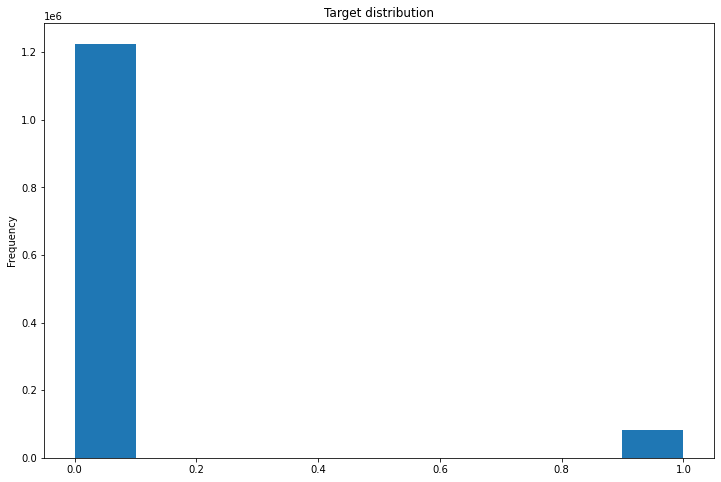

In [ ]:
df['target'].plot(kind='hist', title='Target distribution')

In [ ]:
from sklearn.model_selection import train_test_split
train_df, remaining = train_test_split(df, random_state=42, train_size=0.01, stratify=df.target.values)
valid_df, _ = train_test_split(remaining, random_state=42, train_size=0.001, stratify=remaining.target.values)
train_df.shape, valid_df.shape

((13061, 3), (1293, 3))

In [ ]:
train_df.target.head(15).values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [ ]:
train_df.question_text.head(15).values

array(['What is your experience living in Venezuela in the current crisis? (2018)',
       'In which state/city the price of property is highest?',
       'Do rich blacks also call poor whites, “White Trash”?',
       'Should my 5 yr old son and 2 yr old daughter spend the summer with their father, after a domestic violent relationship?',
       'Why do we have parents?',
       'Do we experience ghost like Murphy did in Interstellar?',
       'Are Estoniano women beautiful?',
       'There was a Funny or Die video called Sensitivity Hoedown that got pulled. Does anyone know why?',
       'Is it a good idea to go in fully mainstream classes, even if I have meltdowns that might disrupt people?',
       'What classifies a third world country as such?',
       'Is being a pilot safe?',
       'Who is Illiteratendra Modi? Why does he keep with him a Rs 1 lakh pen?',
       'Have modern management strategies such as Total supply Chain Management applied to education? Can they be?',
       '

## TensorFlow Hub for Natural Language Processing

In [ ]:
module_url = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

## Define Function to Build and Compile Models

In [ ]:
from pandas.core.arrays.sparse import dtype
def train_and_evaluate_model(module_url, embed_size, name, trainable=False):
  hub_layer = hub.KerasLayer(module_url, input_shape =[ ],output_shape=[embed_size], dtype=tf.string, trainable=trainable)
  model = tf.keras.models.Sequential([
                                      hub_layer,
                                      tf.keras.layers.Dense(256, activation='relu'),
                                      tf.keras.layers.Dense(64, activation='relu'),
                                      tf.keras.layers.Dense(1, activation='sigmoid')
  ]) 
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.losses.BinaryCrossentropy(),
                metrics=[tf.metrics.BinaryAccuracy(name='accuracy')])
  model.summary()
  history= model.fit(train_df['question_text'], train_df['target'],
                     epochs=100,
                     batch_size=32,
                     validation_data=(valid_df['question_text'], valid_df['target']),
                     callbacks=[tfdocs.modeling.EpochDots(),
                                tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,mode='min'),
                                tf.keras.callbacks.TensorBoard(logdir/name)],
                     verbose=0)
  return history

## Train Various Text Classification Models

In [ ]:
histories = {}

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [ ]:
histories['universal-sentence-encoder-large'] = train_and_evaluate_model(module_url, embed_size=512, name='universal-sentence-encoder-large', trainable=False)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 512)               147354880 
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 dense_16 (Dense)            (None, 64)                16448     
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 147,502,721
Trainable params: 147,841
Non-trainable params: 147,354,880
_________________________________________________________________

Epoch: 0, accuracy:0.9378,  loss:0.2966,  val_accuracy:0.9381,  val_loss:0.1700,  
...........

## Compare Accuracy and Loss Curves

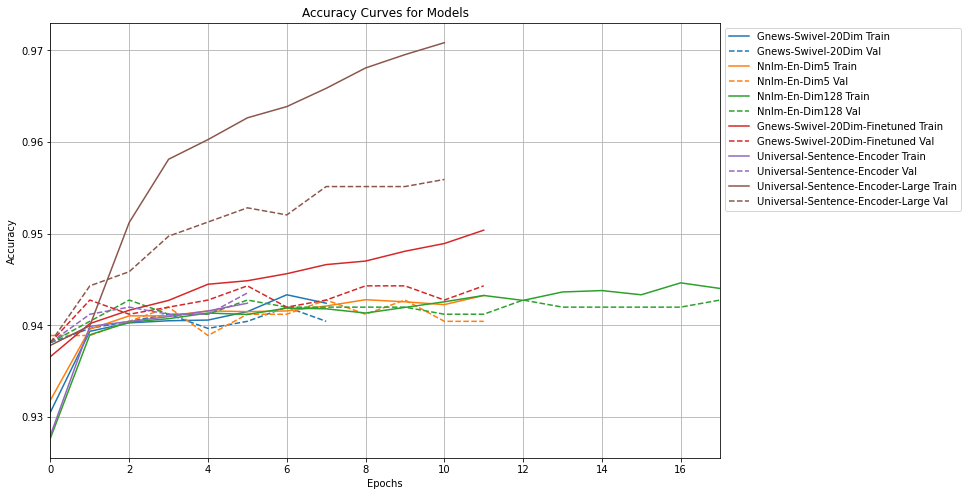

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

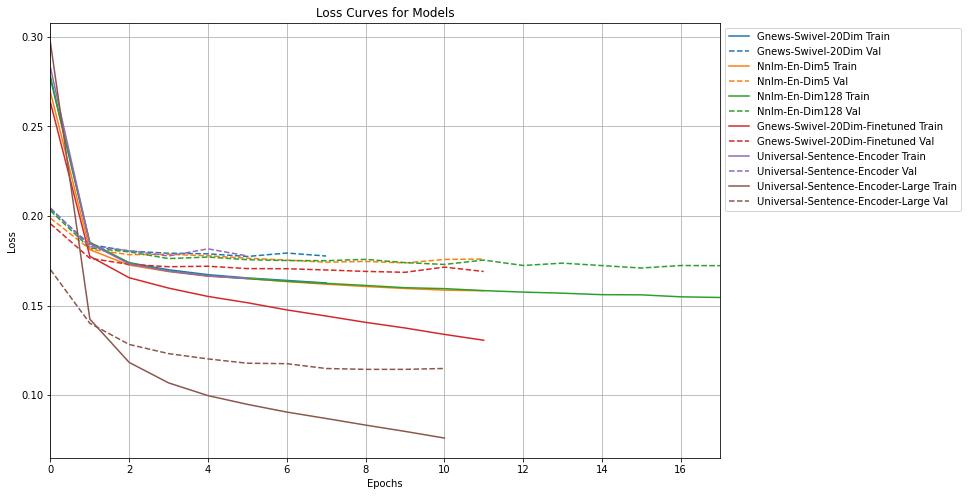

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()

## Fine-tune Model from TF Hub

##  Train Bigger Models and Visualize Metrics with TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {logdir}